<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**It does not matter how slowly you go as long as you do not stop - Confucius**

# Chapter 7: Relationships between variables

So far we have only looked at one variable at a time. In this chapter we look at relationships between variables. Two variables are related if knowing one gives you information about the other. For example, height and weight
are related; people who are taller tend to be heavier. Of course, it is not a perfect relationship: there are short heavy people and tall light ones. But if you are trying to guess someone’s weight, you will be more accurate if you
know their height than if you don’t.

The code for this chapter is in scatter.py.

## Scatter plots

The simplest way to check for a relationship between two variables is a **scatter plot**, but making a good scatter plot is not always easy. As an example, plot weight versus height for the respondents in the BRFSS.

In [0]:
from Thinkstats2 import brfss
import thinkstats2
import matplotlib.pyplot as plt
import numpy as np
import thinkplot
import seaborn as sns
%matplotlib inline

In [0]:
df = brfss.ReadBrfss(nrows=None, filename='Think_Stats/Thinkstats2/CDBRFS08.ASC.gz')

In [0]:
df.dropna(inplace = True)
df.reset_index()
df.tail()

,age,sex,wtyrago,finalwt,wtkg2,htm3
414504,23.0,1,84.090909,43.439320,88.64,191.0
414505,49.0,2,70.454545,6.216538,72.73,170.0
414506,45.0,1,86.363636,20.617560,90.91,178.0
414507,52.0,2,89.090909,11.188138,89.09,157.0
414508,38.0,1,75.000000,25.989792,75.00,178.0


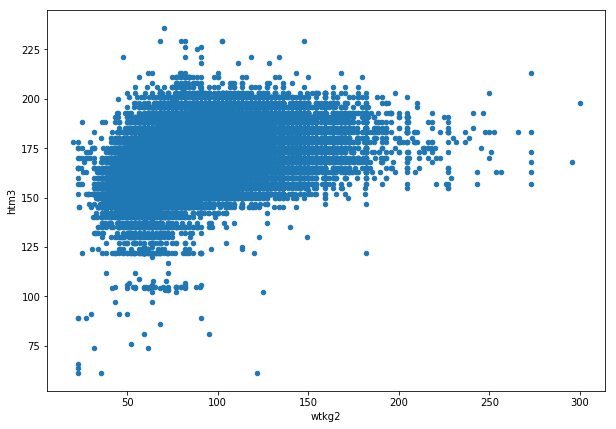

In [0]:
df.plot.scatter('wtkg2', 'htm3', figsize=(10,7))
plt.show()

What is the issue? 

Pick a random sample of 1000 observations and plot it again

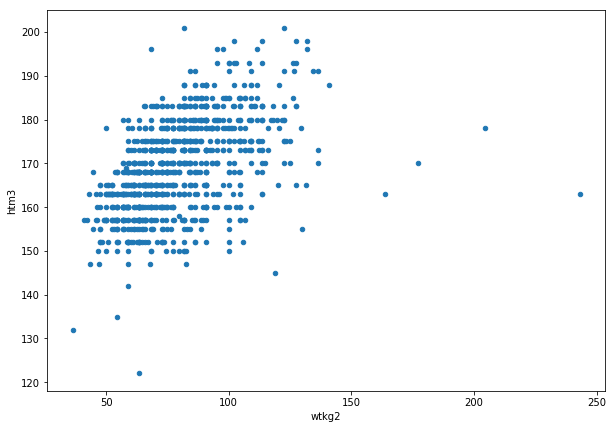

In [0]:
df.sample(1000).plot.scatter('wtkg2','htm3',figsize=(10,7))
plt.show()

But this is not the best representation of the data, because the data are packed into columns. The problem is that the heights are rounded to the nearest inch, converted to centimeters, and then rounded again. Some information is lost in translation.

We can’t get that information back, but we can minimize the effect on the scatter plot by **jittering** the data, which means adding random noise to reverse the effect of rounding off. Since these measurements were rounded to the nearest inch, they might be off by up to 0.5 inches or 1.3 cm. Similarly, the weights might be off by 0.5 kg.

jitter the heights 1.3 cm and the weights 0.5 kg and plot the scatter plot again:


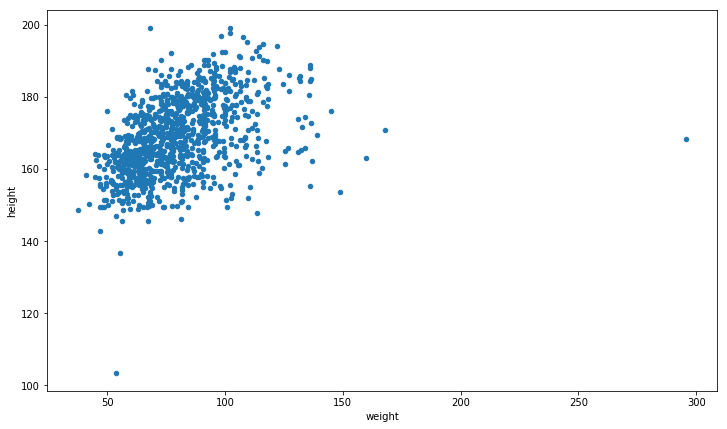

In [0]:
df['height'] = thinkstats2.Jitter(df.htm3, 1.3)
df['weight'] = thinkstats2.Jitter(df.wtkg2, 0.5)
df.sample(1000).plot.scatter('weight','height',figsize = (12,7))
plt.show()

Even with jittering, this is not the best way to represent the data. There are many overlapping points, which hides data in the dense parts of the figure and gives disproportionate emphasis to outliers. This effect is called **saturation**.

We can solve this problem with the alpha parameter, which makes the points partly transparent.

Use alpha in your scatter plot graph:

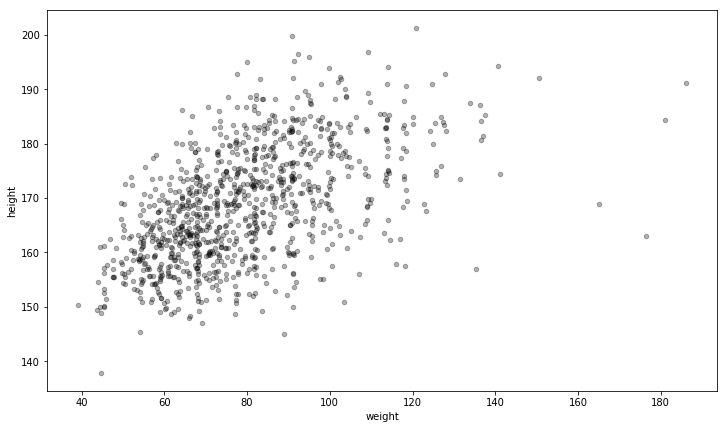

In [0]:
df.sample(1000).plot.scatter('weight','height', alpha = 0.3, figsize = (12,7), color ='k')
plt.show()

Using transparency works well for moderate-sized datasets, but this figure only shows the first 5000 records in the BRFSS, out of a total of 414 509. To handle larger datasets, another option is a hexbin plot, which divides the
graph into hexagonal bins and colors each bin according to how many data points fall in it. thinkplot provides HexBin. 

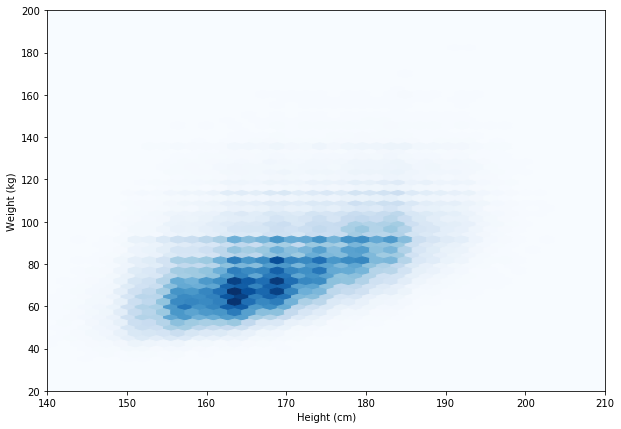

In [0]:
plt.figure(figsize=(10,7))
thinkplot.HexBin(df.height, df.weight)
thinkplot.Config(xlabel='Height (cm)',
                ylabel='Weight (kg)',
                axis=[140, 210, 20, 200],
                legend=False)

Try also the implementation of seaborn [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html):

C:\Users\javier.fernandez\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x504 with 0 Axes>

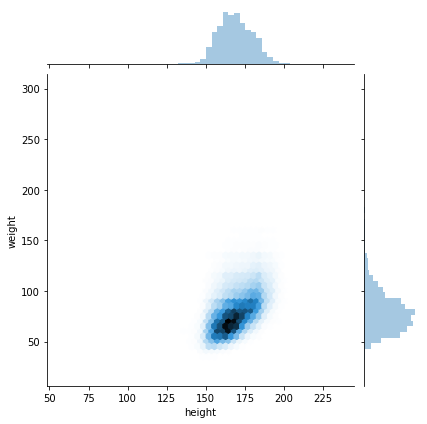

In [0]:
plt.figure(figsize=(10,7))
sns.jointplot(df.height, df.weight,
             kind = 'hex')
plt.show()

The point of this example is that it is not easy to make a scatter plot that shows relationships clearly without introducing misleading artifacts.

## Characterizing relationships#

Scatter plots provide a general impression of the relationship between variables, but there are other visualizations that provide more insight into the nature of the relationship. One option is to bin one variable and plot percentiles of the other.

Try it, group people heights in groups of 5 cm differences 135 -140, 140 -145, etc

In [0]:
df.height.describe()

count    385974.000000
mean        169.013330
std          10.470069
min          57.495914
25%         161.463052
50%         168.350525
75%         176.645761
max         235.679401
Name: height, dtype: float64

In [0]:
heights = np.arange(50,245,5)
intervals = []
for panda in df.height:
    for value in heights:
        if panda < value:
            intervals.append(f'{value}-{value+5}')
            break
df['interval'] = intervals

Calculate a list for each of the weights on the 25 50 and 75 percentile of each of the groups.

In [0]:
groups = df.groupby('interval')

In [0]:
mean_heights = groups.mean().height
cdfs = [thinkstats2.Cdf(group.weight) for i, group in groups]

Plot one line for each of the percentile weights for the average height of that group.

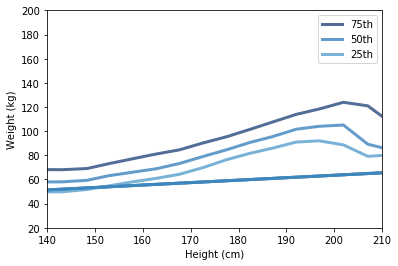

In [0]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)

thinkplot.Config(xlabel='Height (cm)',
                ylabel='Weight (kg)',
                axis=[140, 210, 20, 200],
                legend=True)

## Correlation 

A **correlation** is a statistic intended to quantify the strength of the relationship between two variables.

A challenge in measuring correlation is that the variables we want to compare are often not expressed in the same units. And even if they are in the same units, they come from different distributions.

There are two common solutions to these problems:

1. Transform each value to a **standard scores**, which is the number of standard deviations from the mean. This transform leads to the “Pearson product-moment correlation coefficient.”

2. Transform each value to its **rank**, which is its index in the sorted list of values. This transform leads to the “Spearman rank correlation coefficient.”

If X is a series of n values, x i , we can convert to standard scores by subtracting the mean and dividing by the standard deviation: zi = (xi − μ)/σ.

The numerator is a deviation: the distance from the mean. Dividing by σ standardizes the deviation, so the values of Z are dimensionless (no units) and their distribution has mean 0 and variance 1.

If X is normally distributed, so is Z. But if X is skewed or has outliers, so does Z; in those cases, it is more robust to use percentile ranks. If we compute a new variable, R, so that r i is the rank of x i , the distribution of R is uniform from 1 to n, regardless of the distribution of X.

## Covariance

**Covariance** is a measure of the tendency of two variables to vary together. If we have two series, X and Y , their deviations from the mean are:

![alt text](Think_Stats/notebookpics/covariance_variation.png "Title")

where x̄ is the sample mean of X and ȳ is the sample mean of Y . If X and Y vary together, their deviations tend to have the same sign.

If we multiply them together, the product is positive when the deviations have the same sign and negative when they have the opposite sign. So adding up the products gives a measure of the tendency to vary together.

Covariance is the mean of these products:

![alt text](Think_Stats/notebookpics/cov_formula.png "Title")

where n is the length of the two series (they have to be the same length).

If you have studied linear algebra, you might recognize that Cov is the dot product of the deviations, divided by their length. So the covariance is maximized if the two vectors are identical, 0 if they are orthogonal, and negative if they point in opposite directions.

Create a implementation in python of the covariance and apply calculate the covariance of the sample:

In [0]:
def covariance(col1, col2):
    return (1/len(col1))*sum((col1-np.mean(col1))*(col2-np.mean(col2)))
covariance(df.height, df.weight)

103.56519331302415

NumPy and pandas also provide implementations of covariance, but both of them apply a correction for small sample sizes that we have not covered yet, and np.cov returns a covariance matrix, which is more than we need for now.

## Pearson’s correlation



Covariance is useful in some computations, but it is seldom reported as a summary statistic because it is hard to interpret. Among other problems, its units are the product of the units of X and Y . For example, the covariance of weight and height in the BRFSS dataset is 113 kilogram-centimeters, whatever that means.

One solution to this problem is to divide the deviations by the standard deviation, which yields standard scores, and compute the product of standard scores:

![alt text](Think_Stats/notebookpics/standard_score.png "Title")

Where S X and S Y are the standard deviations of X and Y . The mean of these products is

![alt text](Think_Stats/notebookpics/pearson2.png "Title")

Or we can rewrite ρ by factoring out S X and S Y :

![alt text](Think_Stats/notebookpics/pearson3.png "Title")

This value is called **Pearson’s correlation** after Karl Pearson, an influential early statistician. It is easy to compute and easy to interpret. Because standard scores are dimensionless, so is ρ.

Implement it in python and calculate it from the sample before:

In [0]:
def pcovariance(col1, col2):
    return covariance(col1,col2)/(np.std(col1)*np.std(col2))
pcovariance(df.height, df.weight)

0.5067351638620629

Pearson’s correlation is always between -1 and +1 (including both). If ρ is positive, we say that the correlation is positive, which means that when one variable is high, the other tends to be high. If ρ is negative, the correlation is negative, so when one variable is high, the other is low.

The magnitude of ρ indicates the strength of the correlation. If ρ is 1 or -1, the variables are perfectly correlated, which means that if you know one, you can make a perfect prediction about the other.

Most correlation in the real world is not perfect, but it is still useful. The correlation of height and weight is 0.51, which is a strong correlation compared to similar human-related variables.


## Nonlinear relationships

If Pearson’s correlation is near 0, it is tempting to conclude that there is no relationship between the variables, but that conclusion is not valid. Pearson’s correlation only measures linear relationships. If there’s a nonlinear
relationship, ρ understates its strength.

![alt text](Think_Stats/notebookpics/correlation_exp.png "Title")
    
The top row shows linear relationships with a range of correlations; you can use this row to get a sense of what different values of ρ look like. The second row shows perfect correlations with a range of slopes, which demonstrates that correlation is unrelated to slope (we’ll talk about estimating slope soon). The third row shows variables that are clearly related, but because the relationship is nonlinear, the correlation coefficient is 0.

The moral of this story is that you should always look at a scatter plot of your data before blindly computing a correlation coefficient.

## Spearman’s rank correlation

Pearson’s correlation works well if the relationship between variables is linear and if the variables are roughly normal. But it is not robust in the presence of outliers.

Spearman’s rank correlation is an alternative that mitigates the effect of outliers and skewed distributions. To compute Spearman’s correlation, we have to compute the rank of each value, which is its index in the sorted sample. For example, in the sample [1, 2, 5, 7] the rank of the value 5 is 3, because it appears third in the sorted list. Then we compute Pearson’s correlation for the ranks.

Implement it in python and calculate it from the sample before:

In [0]:
def scovariance(col1, col2):
    col1 = col1.rank()
    col2 = col2.rank()
    return covariance(col1,col2)/(np.std(col1)*np.std(col2))
scovariance(df.height, df.weight)

0.5376183765733528

The Spearman rank correlation for the BRFSS data is 0.54, a little higher than the Pearson correlation, 0.51. There are several possible reasons for the difference, including:

- If the relationship is nonlinear, Pearson’s correlation tends to underestimate the strength of the relationship.

- Pearson’s correlation can be affected (in either direction) if one of the distributions is skewed or contains outliers. Spearman’s rank correlation is more robust.

In the BRFSS example, we know that the distribution of weights is roughly lognormal; under a log transform it approximates a normal distribution, so it has no skew. So another way to eliminate the effect of skewness is to compute Pearson’s correlation with log-weight and height:

In [0]:
thinkstats2.Corr(df.htm3, np.log(df.wtkg2))

0.5340575205036797

The result is 0.53, close to the rank correlation, 0.54. So that suggests that skewness in the distribution of weight explains most of the difference between Pearson’s and Spearman’s correlation.

## Correlation and causation

If variables A and B are correlated, there are three possible explanations: A causes B, or B causes A, or some other set of factors causes both A and B. These explanations are called “causal relationships”.

Correlation alone does not distinguish between these explanations, so it does not tell you which ones are true. This rule is often summarized with the phrase “Correlation does not imply causation,” which is so pithy it has its own Wikipedia page: http://wikipedia.org/wiki/Correlation_does_not_imply_causation.

So what can you do to provide evidence of causation?

1. Use time. If A comes before B, then A can cause B but not the other way around (at least according to our common understanding of causation). The order of events can help us infer the direction of causation, but it does not preclude the possibility that something else causes both A and B.

2. Use randomness. If you divide a large sample into two groups at random and compute the means of almost any variable, you expect the difference to be small. If the groups are nearly identical in all variables but one, you can eliminate spurious relationships. This works even if you don’t know what the relevant variables are, but it works even better if you do, because you can check that the groups are identical.

These ideas are the motivation for the **randomized controlled trial**, in which subjects are assigned randomly to two (or more) groups: a **treatment group** that receives some kind of intervention, like a new medicine, and a
**control group** that receives no intervention, or another treatment whose effects are known.

A randomized controlled trial is the most reliable way to demonstrate a causal relationship, and the foundation of science-based medicine (see http://wikipedia.org/wiki/Randomized_controlled_trial).

Unfortunately, controlled trials are only possible in the laboratory sciences, medicine, and a few other disciplines. In the social sciences, controlled experiments are rare, usually because they are impossible or unethical.

An alternative is to look for a natural experiment, where different “treatments” are applied to groups that are otherwise similar. One danger of natural experiments is that the groups might differ in ways that are not
apparent. You can read more about this topic at http://wikipedia.org/wiki/Natural_experiment.

In some cases it is possible to infer causal relationships using **regression analysis**, which is the topic of Chapter 11.

